In [1]:
import snntorch as snn
from snntorch import utils
from snntorch import spikegen
from snntorch import spikeplot as splt
from snntorch import functional as SF


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from celluloid import Camera

In [2]:
# DataLoader Arguments
batch_size = 128
data_path = '/data/mnist'

dtype = torch.float
#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Select Dataset and define Transform
transform = transforms.Compose([transforms.Resize((10, 10)),
                                transforms.Grayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
indices = (mnist_train.targets == 0) | (mnist_train.targets == 1) | (mnist_train.targets == 2) | (mnist_train.targets == 3) 
mnist_train.data, mnist_train.targets = mnist_train.data[indices], mnist_train.targets[indices]

mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
indices = (mnist_test.targets == 0) | (mnist_test.targets == 1) | (mnist_test.targets == 2) | (mnist_test.targets == 3) 
mnist_test.data, mnist_test.targets = mnist_test.data[indices], mnist_test.targets[indices]

print(f"The size of train_set is {len(mnist_train)}")    # 24754
print(f"The size of test_set is {len(mnist_test)}")      # 4157

# Create DataLoaders, load multiple samples up into memory in batches
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

The size of train_set is 24754
The size of test_set is 4157


In [9]:
# Network Architecture: 100 - 200 - 4
num_inputs = 10*10  
num_hidden = 200
num_outputs = 4   # 4 outputs classes: 0, 1, 2, 3

# Temporal Dynamics
num_steps = 10      # run for 10 time steps
beta = 0.95 

# Define the network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initialize layers
        # Input: Latency_spike X[t] and U[t-1], Neuron output: Spike S[t] and U[t]  
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, threshold=0.2)  
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, threshold=0.2)
        
    def forward(self, x):
        
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the finial laye
        cur1_rec = []
        cur2_rec = []
        spk2_rec = []
        mem2_rec = []
        
        spike_data = spikegen.latency(x, num_steps=num_steps, threshold=0.001, clip=True, normalize=True, linear=True) 
        for latency_data in spike_data:
            cur1 = self.fc1(latency_data)          # Spike[t] x weight --> post-synaptic current
            spk1, mem1 = self.lif1(cur1, mem1)   # post-syn current + decayed membrane --> mem[t+1]
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
#             cur1_rec.append(cur1)            
            cur2_rec.append(cur2)
            spk2_rec.append(spk2)
#             mem2_rec.append(mem2)
        
        # Convert lists to tensors: Concatenates a sequence of tensors along a new dimension(time).
        return torch.stack(spk2_rec, dim=0), torch.stack(cur2_rec, dim=0)
    
net = Net()

In [10]:
# pass data into the network, sum the spikes_output over time and compare the neuron with the highest number of spikes with the target
def print_batch_accuracy(data, targets, train=True):
    output, _ = net(data.reshape(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)                       # max(1):return the max value and indices of each row
    acc = np.mean((targets == idx).detach().cpu().numpy())
    
    if train:
        print(f"Train set accuracy for single minibatch: {acc*100: .2f}%")
    else:
        print(f"Test set accuracy for single minibatch: {acc*100: .2f}%")
        
    return acc*100

In [11]:
net = Net()
net.load_state_dict(torch.load('10x10_Latency3.pt'), strict=False)   # strict=False: ignore non-matching keys

<All keys matched successfully>

In [12]:
# ### Test set accuracy

total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
    net.eval()
    for data, targets in test_loader:
        # forward pass
        test_spk, cur2_rec = net(data.reshape(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 4003/4157
Test Set Accuracy: 96.30%


torch.Size([10, 61, 4])


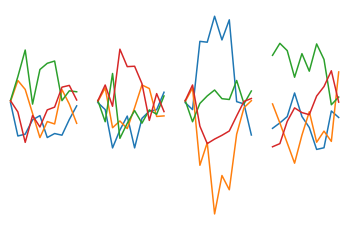

In [13]:
#  mem_rec contains the traces of 4 neuron membrane potentials across 10 time steps in duration
print(cur2_rec.size())

#  Plot
splt.traces(cur2_rec, dim=(1, 4))

In [15]:
cur_results = cur2_rec[:, 0, :].to('cpu')
print(cur_results.size())

torch.Size([10, 4])


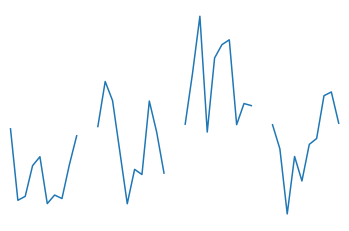

In [16]:
splt.traces(cur_results, dim=(1, 4))

In [28]:
def plot_cur_spk(cur, spk, title=False):
  # Generate Plots
  fig, ax = plt.subplots(2, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1]})

  # Plot Output current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_yticks([])
  ax[0].set_xlim([0, 9])
  ax[0].set_ylabel("Output Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[1], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  ax[1].set_ylim([0, 3]) 

  plt.show()

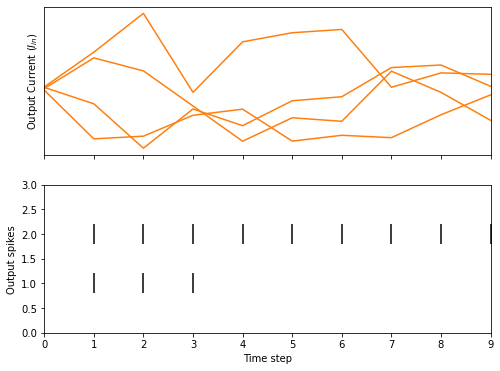

In [29]:
plot_cur_spk(cur_results, test_spk[:, 0, :].to('cpu'), title="")

In [30]:
print(targets[0])

tensor(2)
